# Read input data from external sheets...play with economics then

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import matplotlib as mpl
#enable latex editing
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)
import matplotlib.pylab as pylab
params = {'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#might need this to get the movie output working
%matplotlib notebook 

In [2]:
from ipynb.fs.full.NPV_and_LCOE import NPV,NPV2,LCOE  #need: pip install ipynb

In [3]:
filename="../../Data/Energy_src_parameters_Jani2019.xlsx"  #Has collection of different parameters from different sources
#some artistic license has been used in adding missing entries

In [4]:
xl = pd.ExcelFile(filename)

In [5]:
names=xl.sheet_names 

In [6]:
print(names)

['Parameters ATB', 'Parameters Fraunhofer 2018', 'Parameters LUT', 'Parameters Narrow', 'References']


In [7]:
for i in range(len(names)-1):
    df = pd.read_excel(filename,sheet_name=names[i]) 

In [8]:
#df = pd.read_excel(filename,sheet_name=names[0]) #ATB
df = pd.read_excel(filename,sheet_name=names[2]) #LUT
#df = pd.read_excel(filename,sheet_name=names[1]) #Fraunhofer...somewhat
#df = pd.read_excel(filename,sheet_name=names[3]) #Playground with small uncertainty

In [9]:
print(df.shape)

(21, 10)


In [10]:
keynames=df.keys()

In [11]:
dimensions=df.shape

In [12]:
keynames

Index(['Mostly LUT parameters (except ranges)', 'Units', 'Wind onshore',
       'Wind offshore', 'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT',
       'Natural gas OCGT', 'Coal'],
      dtype='object')

In [13]:
#How many techs have been implemented? 1st two columns are parameter names and units
ntech=dimensions[1]-2
#How many parameters each have 
nparams=dimensions[0]

In [14]:
#rows=dimensions[0]-1
#columns=dimensions[1]-1

# Read the technology data

In [15]:
print(nparams)

21


In [16]:
techdata=np.zeros([nparams,ntech])

In [17]:
#Parameter names
param_names=df[keynames[0]]
print(param_names)

0                        CAPEX min
1                    CAPEX typical
2                        CAPEX max
3                         lifetime
4            Construction time min
5        Construction time typical
6            Construction time max
7                Discount rate min
8                Discount rate max
9              Capacity factor min
10         Capacity factor typical
11             Capacity factor max
12                       FIXED O&M
13                    Variable O&M
14                       Heat rate
15    Fuel cost min primary energy
16    Fuel cost max primary energy
17           Exchange euro to euro
18               Fuel cost min MWh
19               Fuel cost max MWh
20                   CO2 intensity
Name: Mostly LUT parameters (except ranges), dtype: object


In [18]:
for i in range(ntech):
    #test=pd.DataFrame(df,columns=[keynames[i+2]])
    test=df[keynames[i+2]]
    techdata[:,i]=test[0:]

In [19]:
test[0:]

0     1300.000000
1     1800.000000
2     2200.000000
3       40.000000
4        5.000000
5        6.000000
6        6.000000
7        0.010000
8        0.100000
9        0.700000
10       0.700000
11       0.930000
12       0.000000
13      16.620000
14       8.800000
15       0.011823
16       0.014000
17       1.000000
18      33.780000
19      40.000000
20       1.183000
Name: Coal, dtype: float64

In [20]:
print(techdata.shape)

(21, 8)


In [21]:
techdata[12,5]

0.0

1. Read the parameters needed for net present value calculation. Careful with the order!
2. Generate random samples for those that are uncertain
3. Compute the NPV for this particular set of parameters

In [22]:
i=0
x=0
co=0
CO2samples=5
co2min=0
co2max=40.0  #euros/ton CO2
CO2v=np.linspace(co2min,co2max,CO2samples)
samples=20000
NPV_techv=np.zeros([samples,CO2samples,ntech])
LCOE_techv=np.zeros([samples,CO2samples,ntech])
It0v=np.zeros([samples,CO2samples,ntech])
rv=np.zeros([samples,CO2samples,ntech])
cfv=np.zeros([samples,CO2samples,ntech])
wholesalemin=40   #20
wholesalemax=60   #80
It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])
n=int(techdata[3,i])
construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
r=np.random.uniform(low=techdata[7,i],high=techdata[8,i])
OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
OMfixed=techdata[12,i]
CO2intensity=techdata[20,i]  #tons CO2/MWh
NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesalemin,wholesalemax)/It0
print(NPV_techv[x,co,i])

-0.08207326038189586


In [23]:
OMkwh

0.0077

In [35]:
i=0
print('Techonology: ',keynames[i+2],i)

Techonology:  Wind onshore 0


In [25]:
#Loop over all techs and generate all samples
for i in range(ntech):
    print('Techonology: ',keynames[i+2],i)
    n=int(techdata[3,i])
    OMfixed=techdata[12,i]
    CO2intensity=techdata[20,i]
    for co in range(CO2samples):
        for x in range(samples):
            It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])            
            construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
            cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
            r=np.random.uniform(low=techdata[7,i],high=techdata[8,i])
            rv[x,co,i]=r
            It0v[x,co,i]=It0
            cfv[x,co,i]=cf
            OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
            NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesalemin,wholesalemax)/It0
            LCOE_techv[x,co,i]=LCOE(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed)*1000 #euros/MWh

Techonology:  Wind onshore 0
Techonology:  Wind offshore 1
Techonology:  PV 2
Techonology:  PV rooftop 3
Techonology:  Nuclear 4
Techonology:  Natural gas CCGT 5
Techonology:  Natural gas OCGT 6
Techonology:  Coal 7


In [27]:
#write the calculated samples into a file: not optimal, but in case needed...
import csv
np.savetxt("./data/samples_NPV.csv", NPV_techv[:,0,:], delimiter=",")
np.savetxt("./data/samples_LCOE.csv", LCOE_techv[:,0,:], delimiter=",")
np.savetxt("./data/samples_It0.csv", It0v[:,0,:], delimiter=",")
np.savetxt("./data/samples_r.csv", rv[:,0,:], delimiter=",")
np.savetxt("./data/samples_cf.csv", cfv[:,0,:], delimiter=",")

In [ ]:
import csv
from numpy import genfromtxt
#Read from existing csv file 
NPV_techv[:,0,:]=genfromtxt('./data/samples_NPV.csv', delimiter=',')
LCOE_techv[:,0,:]=genfromtxt('./data/samples_LCOE.csv', delimiter=',')
cfv[:,0,:]=genfromtxt('./data/samples_cf.csv', delimiter=',')
rv[:,0,:]=genfromtxt('./data/samples_r.csv', delimiter=',')
It0v[:,0,:]=genfromtxt('./data/samples_It0.csv', delimiter=',')

In [26]:
#Native numpy format save for speed and for saving space
np.save('./data/samples_NPV.npy', NPV_techv)
np.save('./data/samples_LCOE.npy', LCOE_techv)
np.save('./data/samples_It0.npy', It0v)
np.save('./data/samples_r.npy', rv)
np.save('./data/samples_cf.npy', cfv)

In [29]:
#Read existing samples
NPV_techv=np.load('./data/samples_NPV.npy')
LCOE_techv=np.load('./data/samples_LCOE.npy')
It0v=np.load('./data/samples_It0.npy')
rv=np.load('./data/samples_r.npy')
cfv=np.load('./data/samples_cf.npy')

In [22]:
#Loop over all techs and generate all samples let the dicount rate go from 0...4 window to 6...10 window
#Use to make a movie of the discount rate sweep
loopsamples=15
NPV_techv=np.zeros([samples,loopsamples,ntech])
LCOE_techv=np.zeros([samples,loopsamples,ntech])
rminv=np.linspace(0,0.06,loopsamples)
rwidth=0.04  #width of the discount rate random number
rmaxv=np.linspace(0+rwidth,0.06+rwidth,loopsamples)
for i in range(ntech):
    print('Techonology: ',keynames[i+2],i)
    n=int(techdata[3,i])
    OMfixed=techdata[12,i]
    CO2intensity=techdata[20,i]
    for co in range(loopsamples):        
        for x in range(samples):
            It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])            
            construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
            cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
            r=np.random.uniform(low=rminv[co],high=rmaxv[co])            
            OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
            NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesalemin,wholesalemax)/It0
            LCOE_techv[x,co,i]=LCOE(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed)*1000 #euros/MWh

Techonology:  Wind onshore 0
Techonology:  Wind offshore 1
Techonology:  PV 2
Techonology:  PV rooftop 3
Techonology:  Nuclear 4
Techonology:  Natural gas CCGT 5
Techonology:  Natural gas OCGT 6
Techonology:  Coal 7


In [30]:
import matplotlib.animation as mplanimation

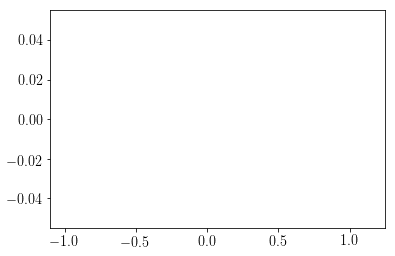

In [35]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
bins_fixed = np.linspace(-1.1, 1.25, 100)
ax.set_xlim(( -1.1, 1.25))
#ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [32]:
np.mean(LCOE_techv[:,0,5])

72.65738705262233

In [40]:
#Function that plots the data for frame=i
def animate_single_LCOE(i):
    #fig = plt.figure(figsize=(15,10))
    #plt.clf()  #Clear whatever was there before
    ti=4
    #global LCOE_techv
    xmin=0
    xmax=np.max(LCOE_techv[:,:,ti])+5
    bins_fixed = np.linspace(-1.1, 1.25, 100)
    minval=LCOE_techv[:,i,ti].min()-0.2
    maxval=LCOE_techv[:,i,ti].max()+0.5
    bins_fixed = np.linspace(minval,maxval, 100)
    #kwargsn={'color':'olive'}
    #kwargsw={'color':'skyblue'}
    #kwargss={'color':'lightsalmon'}
    #kwargsow={'color':'dodgerblue'}
    colorv=['cornflowerblue','royalblue','darkorange','orange','green','chocolate','saddlebrown','dimgray']
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    CO2taxv=np.zeros(1)*CO2v[i]
    #for ti in range(ntech):      
    #plt.subplot(4, 2, ti+1)    
    colorh=colorv[ti]
    yn, xp, _ =plt.hist(LCOE_techv[:,i,ti], bins_fixed,alpha=0.75,density=True,label=keynames[ti+2],color=colorh)
    ymax=yn.max()
    xv=np.ones(2)*np.mean(LCOE_techv[:,i,ti])
    yv=np.zeros(2)
    yv[1]=ymax*1.1
    plt.plot(xv,yv,color=colorh)
    plt.legend(loc='upper right', prop={'size': 20})
    #plt.title("LCOE: CO$_{2}$="+str(round(CO2taxv[i],1))+" €/MWh")
    plt.title("LCOE: CO$_{2}$="+str(round(CO2v[i],1))+" €/MWh")
    plt.xlabel("LCOE €/MWh")
    plt.ylim((0,yv[1]))
    plt.yticks([])
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.tight_layout()
    filenamepng= "./sample_" + str(i)+ ".png"
    #filenamepdf= "./sample" + str(i)+ ".pdf"    
    plt.savefig(filenamepng,dpi=300)
    #plt.savefig(filenamepdf)
    im=plt.show()
    return(plt)

#Function that generates the plots comparing two different technologies for LCOE
def animate_LCOE_compare_two(i,ti1,ti2):
    ti=ti1
    minval1=LCOE_techv[:,i,ti].min()-0.0
    maxval1=LCOE_techv[:,i,ti].max()+5
    minval2=LCOE_techv[:,i,ti2].min()-0.0
    maxval2=LCOE_techv[:,i,ti2].max()+5
    minval=min(minval1,minval2)
    maxval=max(maxval1,maxval2)
    bins_fixed = np.linspace(minval,maxval, 100)
    colorv=['cornflowerblue','royalblue','darkorange','orange','green','chocolate','saddlebrown','dimgray']
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    CO2taxv=np.zeros(1)
    colorh=colorv[ti]
    colorh2=colorv[ti2]
    yn, xp, _ =plt.hist(LCOE_techv[:,i,ti], bins_fixed,alpha=0.5,density=True,label=keynames[ti+2],color=colorh)
    yn2, xp, _ =plt.hist(LCOE_techv[:,i,ti2], bins_fixed,alpha=0.4,density=True,label=keynames[ti2+2],color=colorh2)
    ymax1=yn.max()
    ymax2=yn2.max()
    ymax=max(ymax1,ymax2)
    xv=np.ones(2)*np.mean(LCOE_techv[:,i,ti])
    yv=np.zeros(2)
    yv[1]=ymax*1.1
    plt.plot(xv,yv,color=colorh)
    xv2=np.ones(2)*np.mean(LCOE_techv[:,i,ti2])
    plt.plot(xv2,yv,color=colorh2)
    plt.legend(loc='upper right', prop={'size': 20})
    plt.title("LCOE: CO$_{2}$="+str(round(CO2taxv[i],1))+" €/MWh")
    plt.xlabel("LCOE [€/MWh]")
    plt.ylim((0,yv[1]))
    plt.yticks([])
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.tight_layout()
    filenamepng= "./compare_LCOE"+str(ti)+"_"+str(ti2)+"_" + str(co)+ ".png"
    #filenamepdf= "./sample" + str(co)+ ".pdf"    
    plt.savefig(filenamepng,dpi=300)
    #plt.savefig(filenamepdf)
    im=plt.show()
    return(plt)
    #ims.append([im])

In [38]:
from ipynb.fs.full.animate_functions import animate_single_LCOE

In [37]:
global LCOE_techv

In [36]:
np.shape(LCOE_techv)

(20000, 5, 8)

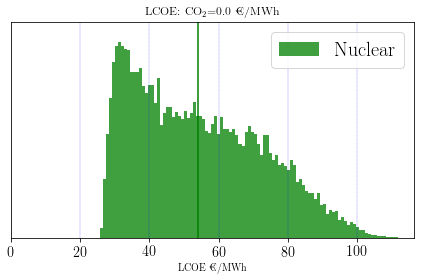

<module 'matplotlib.pyplot' from '/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [41]:
animate_single_LCOE(0)

In [32]:
ani = mplanimation.FuncAnimation(fig, animate_single_LCOE, frames=CO2samples, repeat=True)

In [122]:
HTML(ani.to_html5_video())

ValueError: Invalid file object: <_io.BufferedReader name=66>

In [33]:
ani.save('./CO2.gif', writer='imagemagick', fps=4)

NameError: name 'plt' is not defined

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


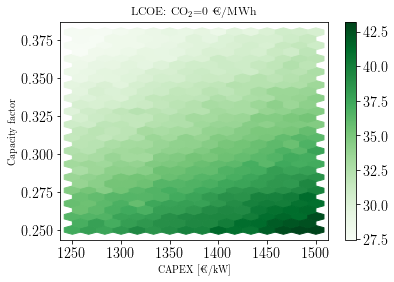

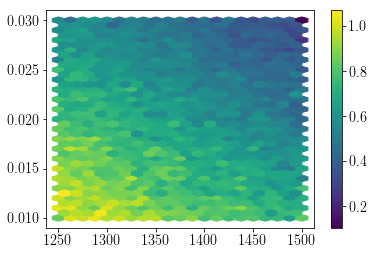

In [31]:
# Make the plot
i=0
ti=0
plt.hexbin(It0v[:,i,ti], cfv[:,i,ti],LCOE_techv[:,i,ti], gridsize=(15,15), cmap=plt.cm.Greens)
plt.colorbar()
plt.title("LCOE: CO$_{2}$="+str(round(0,1))+" €/MWh")
plt.xlabel("CAPEX [€/kW]")
plt.ylabel("Capacity factor")
plt.show()
# We can control the size of the bins:
plt.hexbin(It0v[:,i,ti], rv[:,i,ti],NPV_techv[:,i,ti], gridsize=(20,20) )
plt.colorbar()
plt.show()

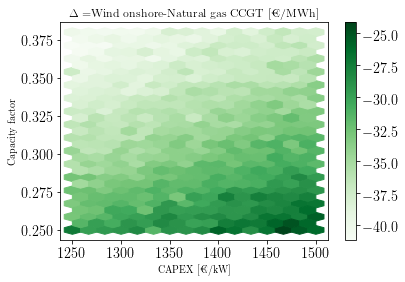

In [44]:
# Make the plot
i=0
ti=0
ti2=5
plt.hexbin(It0v[:,i,ti], cfv[:,i,ti],LCOE_techv[:,i,ti]-LCOE_techv[:,i,ti2], gridsize=(15,15), cmap=plt.cm.Greens)
plt.colorbar()
titletexth="$\Delta=$"+keynames[ti+2]+"-"+keynames[ti2+2]+" [€/MWh]"
#plt.title(" Delta LCOE: CO$_{2}$="+str(round(0,1))+" €/MWh")
plt.title(titletexth)
plt.xlabel("CAPEX [€/kW]")
plt.ylabel("Capacity factor")
plt.show()
# We can control the size of the bins:
#plt.hexbin(It0v[:,i,ti], rv[:,i,ti],NPV_techv[:,i,ti], gridsize=(20,20) )
#plt.colorbar()
#plt.show()


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


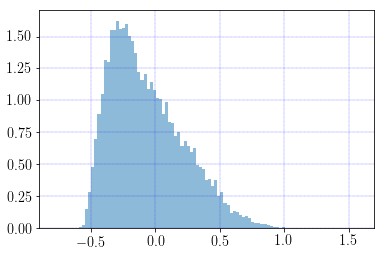

In [23]:
ti=0
i=0
minval=NPV_techv[:,i,ti].min()-0.2
maxval=NPV_techv[:,i,ti].max()+0.5
bins_fixed = np.linspace(minval,maxval, 100)
NPV_techv[:,i,ti].shape
yn, xp, _ =plt.hist(NPV_techv[:,i,ti], bins_fixed,alpha=0.5,density=True)
plt.grid(color='b', linestyle='--', linewidth=0.25)
im=plt.show()

In [ ]:
ti=0
i=0


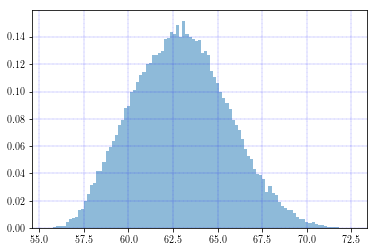

In [27]:
ti=7
i=0
minval=LCOE_techv[:,i,ti].min()-0.2
maxval=LCOE_techv[:,i,ti].max()+0.5
bins_fixed = np.linspace(minval,maxval, 100)
LCOE_techv[:,0,0].shape
yn, xp, _ =plt.hist(LCOE_techv[:,i,ti], bins_fixed,alpha=0.5,density=True)
plt.grid(color='b', linestyle='--', linewidth=0.25)
im=plt.show()

In [34]:
np.mean(NPV_techv[:,i,ti])

-0.06836771712242602

In [35]:
np.mean(LCOE_techv[:,i,ti])

57.87356214394561

In [234]:
0 % 2

0

(4, 2)


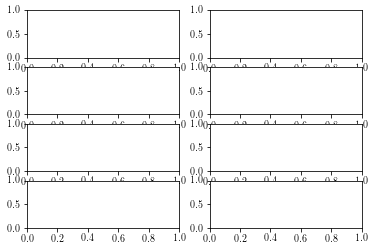

In [164]:
# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()
#fig, ax = plt.subplots(4, 2)
#bins_fixed = np.linspace(-1.1, 1.25, 100)
print(ax.shape)
#for ti in range(ntech):
    #ax[ti].set_xlim(( -1.1, 1.25))
    #line, = ax.plot([], [], lw=2)
#ax.set_ylim((-2, 2))
#line, = ax.plot([], [], lw=2)

In [ ]:
animate(0)

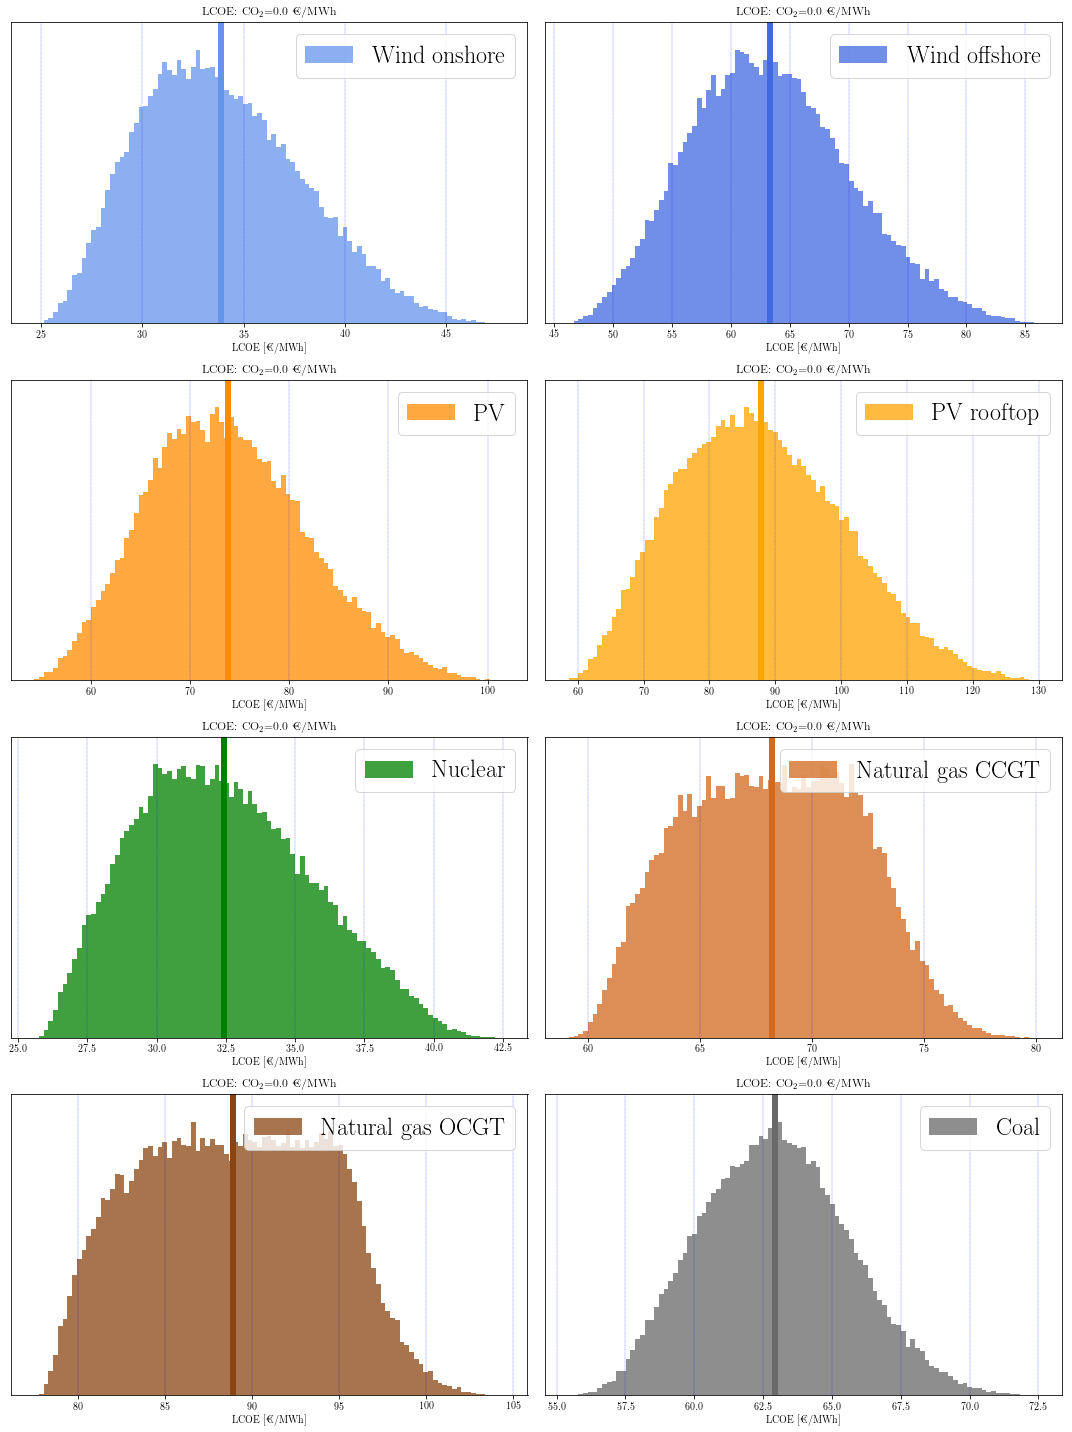

<module 'matplotlib.pyplot' from '/u/33/martikj2/unix/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [29]:
animate_LCOE(0)

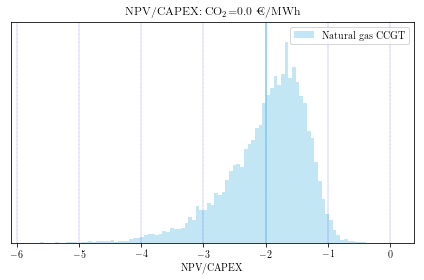

<module 'matplotlib.pyplot' from '/u/33/martikj2/unix/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [227]:
animate_single(0)

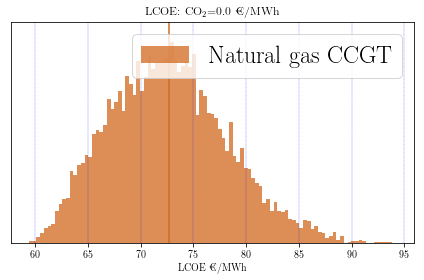

<module 'matplotlib.pyplot' from '/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [44]:
animate_single_LCOE(0)

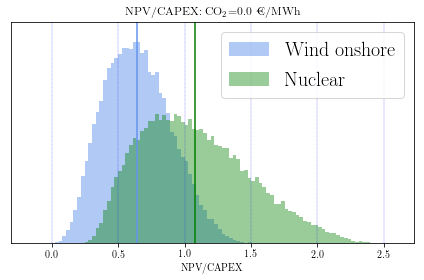

<module 'matplotlib.pyplot' from '/u/33/martikj2/unix/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [40]:
animate_NPV_compare_two(0,0,4)  #0=wind,1=wind os, 2=pv utility, 3=pv roof, 4=nuclear, 5=gas CC 6=gas oc, 7=coal 

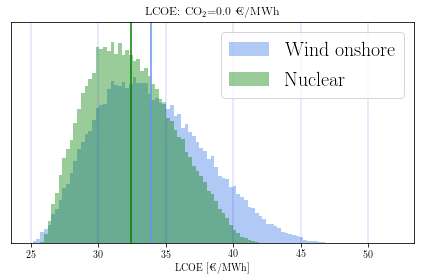

<module 'matplotlib.pyplot' from '/u/33/martikj2/unix/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [55]:
animate_LCOE_compare_two(0,0,4)  #0=wind,1=wind os, 2=pv utility, 3=pv roof, 4=nuclear, 5=gas CC 6=gas oc, 7=coal 

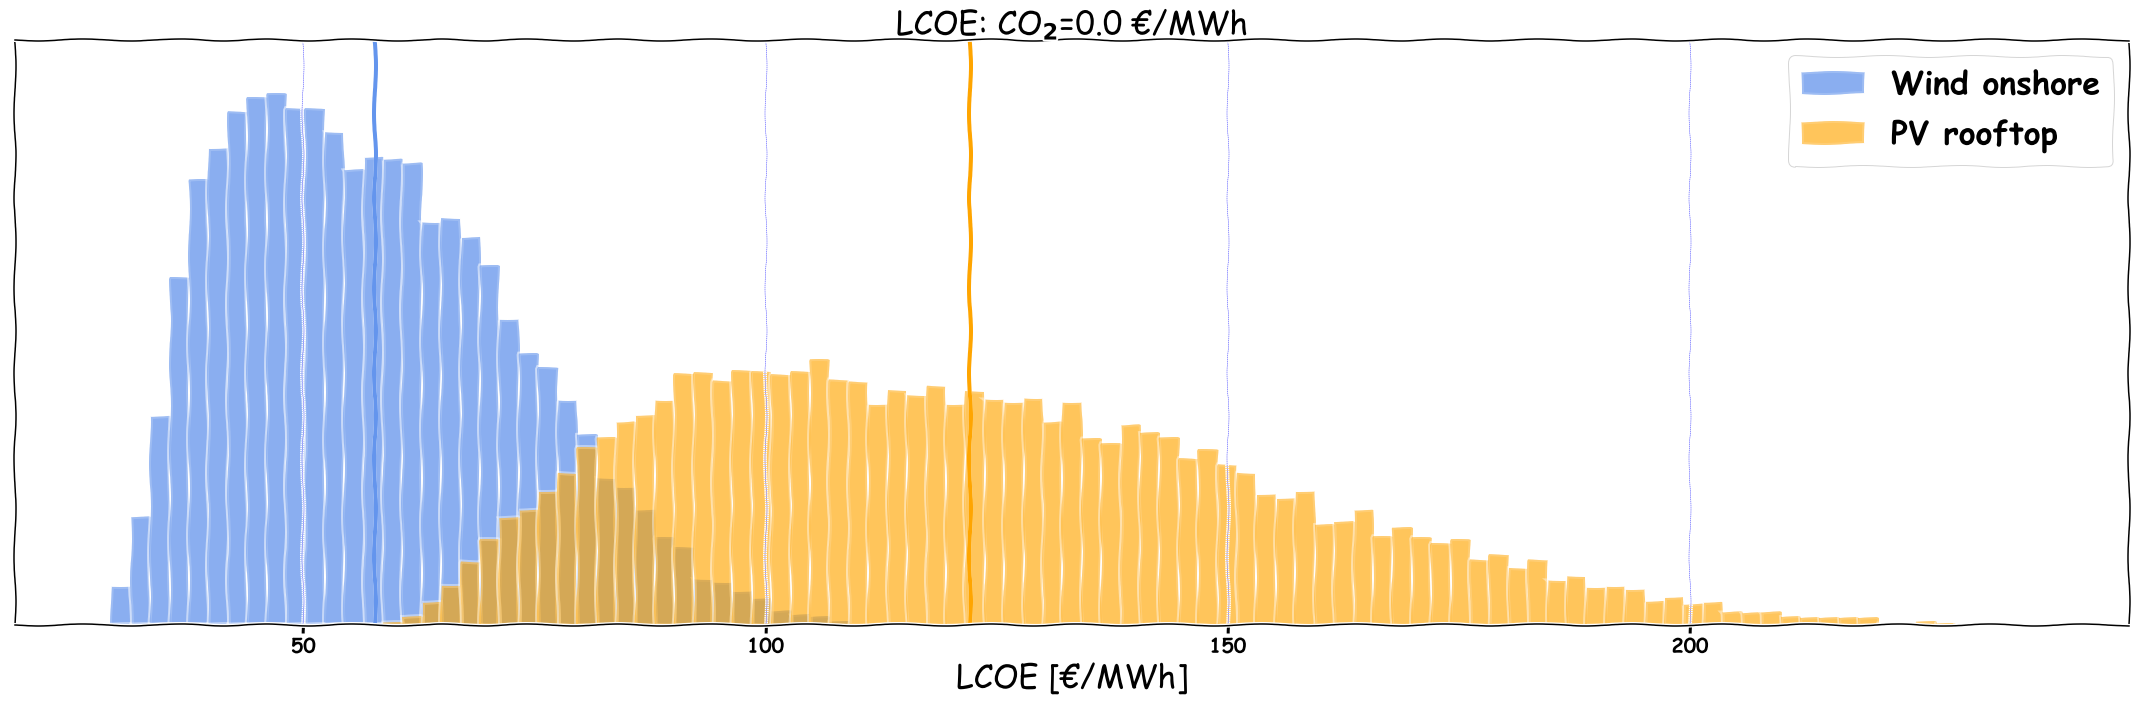

<module 'matplotlib.pyplot' from '/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [52]:
animate_LCOE_compare_two_XKCD(0,0,3)

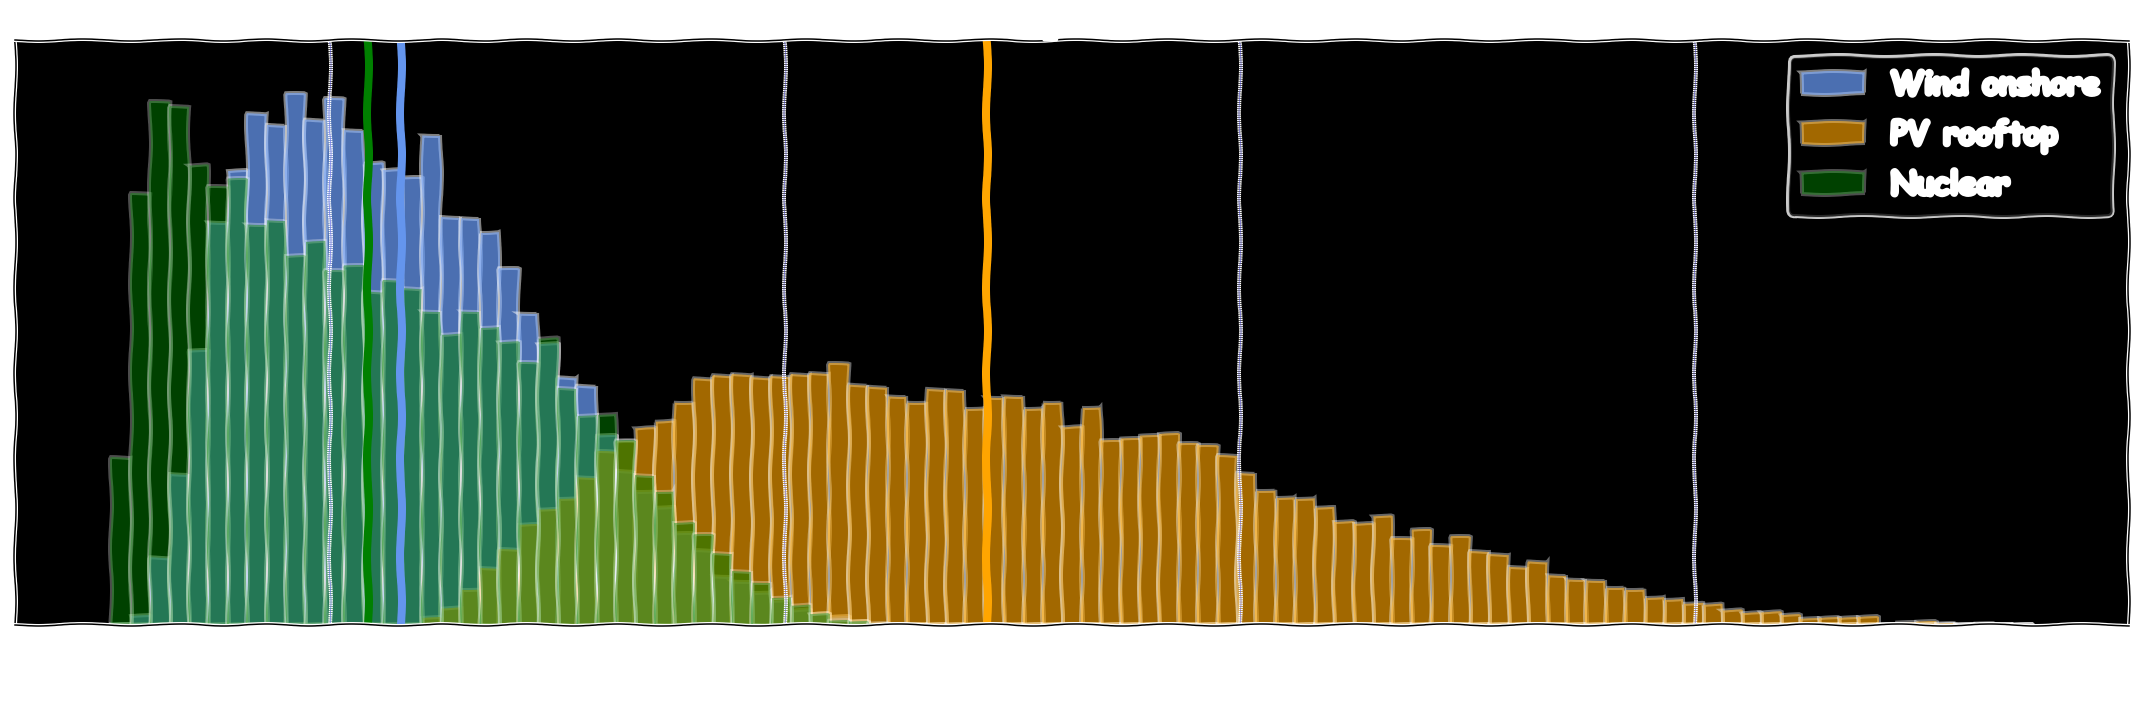

<module 'matplotlib.pyplot' from '/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [61]:
animate_LCOE_compare_three_XKCD(0,0,3,4)